# **Math 156 Project**



## WITH BLOCK

In [ ]:
#Import Packages
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy
import tensorflow.compat.v1 as tf

# disabling eager mode
tf.compat.v1.disable_eager_execution()

# Create 2048 Game Simulation


In [ ]:
def create_board():
  """
  Creates a blank game board to imitate the 2048 board
  args: None
  returns: a 4x4 np matrix of zeros
  """

  board = np.zeros([4,4])
  board[0][0] = 1

  return board


def add_tile(mat):
  """
  Adds random value of 2 or 4 to empty squares on the board
  args: matrix of 4x4
  returns: matrix of 4x4 with new tile
  """
  empty_cells = []
  for i in range(len(mat)):
    for j in range(len(mat[0])):
      if(mat[i][j]==0):
              empty_cells.append((i,j))
  if(len(empty_cells)==0):
      return mat

  index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]

  prob = random.random()
  if(prob>=0.9):
      mat[index_pair[0]][index_pair[1]]=4
  else:
      mat[index_pair[0]][index_pair[1]]=2
  return mat

def game_state(mat):
  """
  Checks if the game is finished or not
  args: matrix of 4x4
  returns: False or True and a print statement (False means continue the game "not a loss")
  """

  for i in range(len(mat)-1): #intentionally reduced to check the row on the right and below
      for j in range(len(mat[0])-1): #more elegant to use exceptions but most likely this will be their solution
          if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
              return 'alive'

  for i in range(len(mat)): #check for any zero entries
      for j in range(len(mat[0])):
          if mat[i][j]==0:
              return 'alive'

  for k in range(len(mat)-1): #to check the left/right entries on the last row
      if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
          return 'alive'

  for j in range(len(mat)-1): #check up/down entries on last column
      if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
          return 'alive'

  return 'lose'


In [ ]:
def flip(matrix):
  """
  Reverses a matrix, flips the columns backwards
  This function is used as a helper function to make the writing the control functions easier
  args: matrix of 4x4
  returns: matrix of 4x4 flipped
  """

  # Switches to a np array and the back to make it easier
  matrix = np.array(matrix)
  matrix = np.flip(matrix)
  matrix = matrix.tolist()

  return matrix



def transpose(matrix):
  """
  Transposes a matrix
  This function is used as a helper function to make the writing the control functions easier
  args: matrix of 4x4
  returns: matrix of 4x4 transposed
  """

  # Switches to a np array and the back to make it easier
  matrix = np.array(matrix)
  matrix = np.transpose(matrix)
  matrix = matrix.tolist()

  return matrix



def slide(matrix):
  """
  Shifts non zero elements of the matrix to the left (does not add them yet), keeps track of whether it has been slided
  args: matrix of 4x4
  returns: matrix of 4x4 shifted, True or False
  """

  # Create a blank matrix to keep track of which values have been slided
  blank = [[0] * 4 for _ in range(4)]
  done = False

  # Iterate through the matrix and slide the values
  for i in range(len(matrix)):
      count = 0
      for j in range(len(matrix)):
          val = matrix[i][j]

          if val != 0:
              blank[i][count] = val
              count += 1

              if j != count - 1:
                  done = True

  return (blank, done)



def combine(matrix):
  """
  Takes the slided matrix an adds the adjacent squares of same value, keeps track of whether the combine occurred
  args: matrix of 4x4
  returns matrix of 4x4 added
  """

  # Initiate score to 0
  score = 0
  done=False

  # Iterate through the values in the matrix and combine
  for i in range(len(matrix)):
      for j in range(len(matrix) - 1):
          if matrix[i][j] == matrix[i][j+1] and matrix[i][j]!= 0:
              matrix[i][j] *= 2
              score += matrix[i][j]
              matrix[i][j+1] = 0
              done = True

  return (matrix,done,score)

In [ ]:
def up(matrix):
  """
  Moves up in the game
  args: matrix of 4x4
  returns: matrix of 4x4 with an up move applied
  """

  matrix = transpose(matrix)
  matrix, done = slide(matrix)
  temp = combine(matrix)
  matrix = temp[0]
  done = done or temp[1]
  matrix = slide(matrix)[0]
  matrix = transpose(matrix)

  return (matrix, done, temp[2])



def down(matrix):
  """
  Moves down in the game
  args: matrix of 4x4
  returns: matrix of 4x4 with a down move applied
  """

  matrix = flip(transpose(matrix))
  matrix, done = slide(matrix)
  temp = combine(matrix)
  matrix = temp[0]
  done = done or temp[1]
  matrix = slide(matrix)[0]
  matrix = transpose(flip(matrix))

  return (matrix, done, temp[2])



def left(matrix):
  """
  Moves left in the game
  args: matrix of 4x4
  returns: matrix of 4x4 with a left move applied
  """

  matrix, done = slide(matrix)
  temp = combine(matrix)
  matrix = temp[0]
  done = done or temp[1]
  matrix = slide(matrix)[0]

  return (matrix, done, temp[2])

def right(matrix):
  """
  Moves up in the game
  args: matrix of 4x4
  returns: matrix of 4x4 with a right move applied
  """

  matrix = flip(matrix)
  matrix, done = slide(matrix)
  temp = combine(matrix)
  matrix = temp[0]
  done = done or temp[1]
  matrix = slide(matrix)[0]
  matrix = flip(matrix)
  return (matrix, done, temp[2])


# Modeling


In [ ]:
controls = {0:up,1:left,2:right,3:down}

In [ ]:
def change_values(X):
    matrix = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                matrix[0][i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                matrix[0][i][j][power] = 1.0
    return matrix

#find the number of empty cells in the game matrix.
def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

In [ ]:
#hyper parameters
lr = 0.0005

#gamma for Q-learning
gamma = 0.9

#epsilon greedy approach
epsilon = 0.9

#to store states and lables of the game for training
#states of the game
replay_memory = list()

#labels of the states
replay_labels = list()

#capacity of memory
mem_capacity = 6000

In [ ]:
#first convolution layer depth
depth1 = 128

#second convolution layer depth
depth2 = 128

#batch size for batch gradient descent
batch_size = 256

#input units
input_units = 16

#fully connected layer neurons
hidden_units = 512

#output neurons = number of moves
output_units = 4

In [ ]:
#input data
tf_batch_dataset = tf.placeholder(tf.float32,shape=(batch_size,4,4,16))
tf_batch_labels  = tf.placeholder(tf.float32,shape=(batch_size,output_units))

single_dataset   = tf.placeholder(tf.float32,shape=(1,4,4,16))


#CONV LAYERS
#conv layer1 weights
conv1_layer1_weights = tf.Variable(tf.truncated_normal([1,2,input_units,depth1],mean=0,stddev=0.01))
conv1_layer1_biases = tf.Variable(tf.truncated_normal([1,input_units], mean = 0, stddev = 0.01))
conv2_layer1_weights = tf.Variable(tf.truncated_normal([2,1,input_units,depth1],mean=0,stddev=0.01))
conv2_layer1_biases = tf.Variable(tf.truncated_normal([1,input_units], mean = 0, stddev = 0.01))

#conv layer2 weights
conv1_layer2_weights = tf.Variable(tf.truncated_normal([1,2,depth1,depth2],mean=0,stddev=0.01))
conv1_layer2_biases = tf.Variable(tf.truncated_normal([1,depth1], mean = 0, stddev = 0.01))
conv2_layer2_weights = tf.Variable(tf.truncated_normal([2,1,depth1,depth2],mean=0,stddev=0.01))
conv2_layer2_biases = tf.Variable(tf.truncated_normal([1,depth1], mean = 0, stddev = 0.01))


#FUllY CONNECTED LAYERS
expand_size = 2*4*depth2*2 + 3*3*depth2*2 + 4*3*depth1*2
fc_layer1_weights = tf.Variable(tf.truncated_normal([expand_size,hidden_units],mean=0,stddev=0.01))
fc_layer1_biases = tf.Variable(tf.truncated_normal([1,hidden_units],mean=0,stddev=0.01))
fc_layer2_weights = tf.Variable(tf.truncated_normal([hidden_units,output_units],mean=0,stddev=0.01))
fc_layer2_biases = tf.Variable(tf.truncated_normal([1,output_units],mean=0,stddev=0.01))


#model
def model(dataset):
    #layer1
    conv1 = tf.nn.conv2d(dataset,conv1_layer1_weights,[1,1,1,1],padding='VALID')
    conv2 = tf.nn.conv2d(dataset,conv2_layer1_weights,[1,1,1,1],padding='VALID')

    #layer1 relu activation
    relu1 = tf.nn.relu(conv1)
    relu2 = tf.nn.relu(conv2)

    #layer2
    conv11 = tf.nn.conv2d(relu1,conv1_layer2_weights,[1,1,1,1],padding='VALID')
    conv12 = tf.nn.conv2d(relu1,conv2_layer2_weights,[1,1,1,1],padding='VALID')

    conv21 = tf.nn.conv2d(relu2,conv1_layer2_weights,[1,1,1,1],padding='VALID')
    conv22 = tf.nn.conv2d(relu2,conv2_layer2_weights,[1,1,1,1],padding='VALID')

    #layer2 relu activation
    relu11 = tf.nn.relu(conv11)
    relu12 = tf.nn.relu(conv12)
    relu21 = tf.nn.relu(conv21)
    relu22 = tf.nn.relu(conv22)

    #get shapes of all activations
    shape1 = relu1.get_shape().as_list()
    shape2 = relu2.get_shape().as_list()

    shape11 = relu11.get_shape().as_list()
    shape12 = relu12.get_shape().as_list()
    shape21 = relu21.get_shape().as_list()
    shape22 = relu22.get_shape().as_list()

    #expansion
    hidden1 = tf.reshape(relu1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
    hidden2 = tf.reshape(relu2,[shape2[0],shape2[1]*shape2[2]*shape2[3]])

    hidden11 = tf.reshape(relu11,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
    hidden12 = tf.reshape(relu12,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
    hidden21 = tf.reshape(relu21,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
    hidden22 = tf.reshape(relu22,[shape22[0],shape22[1]*shape22[2]*shape22[3]])

    #concatenation
    hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)

    #full connected layers
    hidden = tf.matmul(hidden,fc_layer1_weights) + fc_layer1_biases
    hidden = tf.nn.relu(hidden)

    #output layer
    output = tf.matmul(hidden,fc_layer2_weights) + fc_layer2_biases

    #return output
    return output

#for single example
single_output = model(single_dataset)

#for batch data
logits = model(tf_batch_dataset)

#loss
loss = tf.square(tf.subtract(tf_batch_labels,logits))
loss = tf.reduce_sum(loss,axis=1,keep_dims=True)
loss = tf.reduce_mean(loss)/2.0

#optimizer
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(float(lr), global_step, 1000, 0.90, staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step = global_step)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#loss
losses = []

#scores
scores = []

#to store final parameters
final_parameters = {}

#number of episodes
M = 10000

In [ ]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initialized")

    global epsilon
    global replay_labels
    global replay_memory

    score_array = []

    #for episode with max score
    maximum = -1
    episode = -1

    #total_iters
    total_iters = 1

    #number of back props
    back=0

    for ep in range(M):
        global board
        board = create_board()
        add_tile(board)
        add_tile(board)

        #whether episode finished or not
        finish = 'alive'

        #total_score of this episode
        total_score = 0

        #iters per episode
        local_iters = 1

        while(finish=='alive'):
            prev_board = deepcopy(board)

            #get the required move for this state
            state = deepcopy(board)
            state = change_values(state)
            state = np.array(state,dtype = np.float32).reshape(1,4,4,16)
            feed_dict = {single_dataset:state}
            control_scores = session.run(single_output,feed_dict=feed_dict)

            #find the move with max Q value
            control_buttons = np.flip(np.argsort(control_scores),axis=1)

            #copy the Q-values as labels
            labels = deepcopy(control_scores[0])

            #generate random number for epsilon greedy approach
            num = random.uniform(0,1)

            #store prev max
            prev_max = np.max(prev_board)

            #num is less epsilon generate random move
            if(num<epsilon):
                #find legal moves
                legal_moves = list()
                for i in range(4):
                    temp_board = deepcopy(prev_board)
                    temp_board,_,_ = controls[i](temp_board)
                    if(np.array_equal(temp_board,prev_board)):
                        continue
                    else:
                        legal_moves.append(i)
                if(len(legal_moves)==0):
                    finish = 'lose'
                    continue

                #generate random move.
                con = random.sample(legal_moves,1)[0]

                #apply the move
                temp_state = deepcopy(prev_board)
                temp_state,_,score = controls[con](temp_state)
                total_score += score
                finish = game_state(temp_state)

                #get number of merges
                empty1 = findemptyCell(prev_board)
                empty2 = findemptyCell(temp_state)

                if(finish=='alive'):
                    temp_state = add_tile(temp_state)

                board = deepcopy(temp_state)

                #get next max after applying the move
                next_max = np.max(temp_state)

                #reward math.log(next_max,2)*0.1 if next_max is higher than prev max
                labels[con] = (math.log(next_max,2))*0.1

                if(next_max==prev_max):
                    labels[con] = 0

                #reward is also the number of merges
                labels[con] += (empty2-empty1)

                #get the next state max Q-value
                temp_state = change_values(temp_state)
                temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                feed_dict = {single_dataset:temp_state}
                temp_scores = session.run(single_output,feed_dict=feed_dict)

                max_qvalue = np.max(temp_scores)

                #final labels add gamma*max_qvalue
                labels[con] = (labels[con] + gamma*max_qvalue)

            #generate the the max predicted move
            else:
                for con in control_buttons[0]:
                    prev_state = deepcopy(prev_board)

                    #apply the LEGAl Move with max q_value
                    temp_state,_,score = controls[con](prev_state)

                    #if illegal move label = 0
                    if(np.array_equal(prev_board,temp_state)):
                        labels[con] = 0
                        continue

                    #get number of merges
                    empty1 = findemptyCell(prev_board)
                    empty2 = findemptyCell(temp_state)


                    temp_state = add_tile(temp_state)
                    board = deepcopy(temp_state)
                    total_score += score

                    next_max = np.max(temp_state)

                    #reward
                    labels[con] = (math.log(next_max,2))*0.1
                    if(next_max==prev_max):
                        labels[con] = 0

                    labels[con] += (empty2-empty1)

                    #get next max qvalue
                    temp_state = change_values(temp_state)
                    temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                    feed_dict = {single_dataset:temp_state}
                    temp_scores = session.run(single_output,feed_dict=feed_dict)

                    max_qvalue = np.max(temp_scores)

                    #final labels
                    labels[con] = (labels[con] + gamma*max_qvalue)
                    break

                if(np.array_equal(prev_board,board)):
                    finish = 'lose'

            #decrease the epsilon value
            if((ep>10000) or (epsilon>0.1 and total_iters%2500==0)):
                epsilon = epsilon/1.005


            #change the matrix values and store them in memory
            prev_state = deepcopy(prev_board)
            prev_state = change_values(prev_state)
            prev_state = np.array(prev_state,dtype=np.float32).reshape(1,4,4,16)
            replay_labels.append(labels)
            replay_memory.append(prev_state)


            #back-propagation
            if(len(replay_memory)>=mem_capacity):
                back_loss = 0
                batch_num = 0
                z = list(zip(replay_memory,replay_labels))
                np.random.shuffle(z)
                np.random.shuffle(z)
                replay_memory,replay_labels = zip(*z)

                for i in range(0,len(replay_memory),batch_size):
                    if(i + batch_size>len(replay_memory)):
                        break

                    batch_data = deepcopy(replay_memory[i:i+batch_size])
                    batch_labels = deepcopy(replay_labels[i:i+batch_size])

                    batch_data = np.array(batch_data,dtype=np.float32).reshape(batch_size,4,4,16)
                    batch_labels = np.array(batch_labels,dtype=np.float32).reshape(batch_size,output_units)

                    feed_dict = {tf_batch_dataset: batch_data, tf_batch_labels: batch_labels}
                    _,l = session.run([optimizer,loss],feed_dict=feed_dict)
                    back_loss += l

                    print("Mini-Batch - {} Back-Prop : {}, Loss : {}".format(batch_num,back,l))
                    batch_num +=1
                back_loss /= batch_num
                losses.append(back_loss)

                #store the parameters in a dictionary
                final_parameters['conv1_layer1_weights'] = session.run(conv1_layer1_weights)
                final_parameters['conv1_layer2_weights'] = session.run(conv1_layer2_weights)
                final_parameters['conv2_layer1_weights'] = session.run(conv2_layer1_weights)
                final_parameters['conv2_layer2_weights'] = session.run(conv2_layer2_weights)
                final_parameters['conv1_layer1_biases'] = session.run(conv1_layer1_biases)
                final_parameters['conv1_layer2_biases'] = session.run(conv1_layer2_biases)
                final_parameters['conv2_layer1_biases'] = session.run(conv2_layer1_biases)
                final_parameters['conv2_layer2_biases'] = session.run(conv2_layer2_biases)
                final_parameters['fc_layer1_weights'] = session.run(fc_layer1_weights)
                final_parameters['fc_layer2_weights'] = session.run(fc_layer2_weights)
                final_parameters['fc_layer1_biases'] = session.run(fc_layer1_biases)
                final_parameters['fc_layer2_biases'] = session.run(fc_layer2_biases)

                #number of back-props
                back+=1

                #make new memory
                replay_memory = list()
                replay_labels = list()


            if(local_iters%400==0):
                print("Episode : {}, Score : {}, Iters : {}, Finish : {}".format(ep,total_score,local_iters,finish))

            local_iters += 1
            total_iters += 1

        scores.append(total_score)
        print("Episode {} finished with score {}, result : {} board : {}, epsilon  : {}, learning rate : {} ".format(ep,total_score,finish,board,epsilon,session.run(learning_rate)))
        print()

        if((ep+1)%1000==0):
            print("Maximum Score : {} ,Episode : {}".format(maximum,episode))
            print("Loss : {}".format(J[len(J)-1]))
            print()

        if(maximum<total_score):
            maximum = total_score
            episode = ep
    print("Maximum Score : {} ,Episode : {}".format(maximum,episode))

## Comparing with just Random Moves

In [ ]:
def random_run():
    game = create_board()
    add_tile(game)
    add_tile(game)
    total_score = 0
    while game_state(game) == 'alive':
        move = random.randint(0, 3)
        game,_,score = controls[move](game)
        add_tile(game)
        total_score += score

    #print(game)
    #print('Total Score:',total_score)
    return total_score
    #return game.max_num(), game.get_sum(), game.get_merge_score()

In [ ]:
avg = []
for i in range(500):
  avg.append(random_run())
np.mean(avg)

578.72

In [ ]:
import pandas as pd

table = pd.DataFrame({'Number of Episodes': range(int(M/10), M + int(M/10), int(M/10)), 'Average Score': np.zeros(10), 'Ratio': np.zeros(10)})
for i in range(10):
  num = table.iloc[i,0]
  if num != M:
    score = np.mean(scores[num-25:num+25])
  else:
    score = np.mean(scores[num-25:])
  table.iloc[i,1] = score
  table.iloc[i,2] = score/np.mean(avg)
table

,Number of Episodes,Average Score,Ratio
0,1000,606.24,1.047553
1,2000,642.48,1.110174
2,3000,838.08,1.448161
3,4000,941.76,1.627315
4,5000,893.84,1.544512
5,6000,1049.20,1.812967
6,7000,1131.68,1.955488
7,8000,1340.64,2.316561
8,9000,1388.08,2.398535
9,10000,1385.12,2.393420


from matplotlib import pyplot as plt
table['Number of Episodes'].plot(kind='hist', bins=20, title='Number of Episodes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['Average Score'].plot(kind='hist', bins=20, title='Average Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table['Ratio'].plot(kind='hist', bins=20, title='Ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='Number of Episodes', y='Average Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
table.plot(kind='scatter', x='Average Score', y='Ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Number of Episodes']
  ys = series['Average Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('Number of Episodes', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Number of Episodes')
_ = plt.ylabel('Average Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Number of Episodes']
  ys = series['Ratio']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('Number of Episodes', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Number of Episodes')
_ = plt.ylabel('Ratio')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Number of Episodes']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Number of Episodes'}, axis=1)
              .sort_values('Number of Episodes', ascending=True))
  xs = counted['Number of Episodes']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = table.sort_values('Number of Episodes', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Number of Episodes')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
table['Number of Episodes'].plot(kind='line', figsize=(8, 4), title='Number of Episodes')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['Average Score'].plot(kind='line', figsize=(8, 4), title='Average Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
table['Ratio'].plot(kind='line', figsize=(8, 4), title='Ratio')
plt.gca().spines[['top', 'right']].set_visible(False)

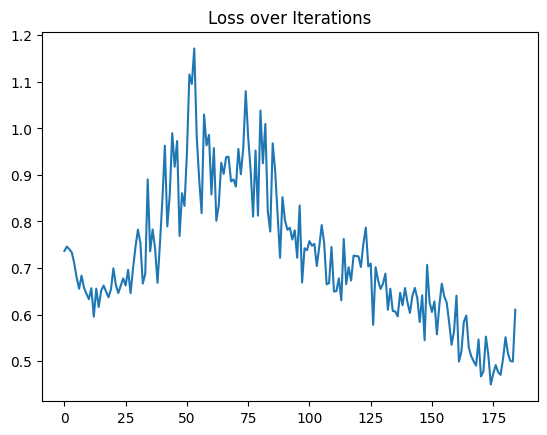

In [ ]:
plt.plot(range(len(losses)), losses)
plt.title('Loss over Iterations')
plt.show()

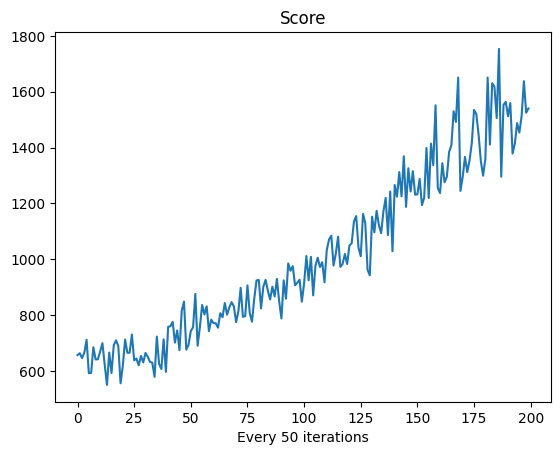

In [ ]:
scores_50 = [np.mean(scores[i*50:i*50+50]) for i in range(int(len(scores)/50))]
plt.plot(range(len(scores_50)), scores_50)
plt.title('Score')
plt.xlabel('Every 50 iterations')
plt.show()